In [ ]:
import re
import pandas as pd
import bs4
import requests
import spacy

In [ ]:
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

In [ ]:
from spacy.matcher import Matcher 
from spacy.tokens import Span 

In [ ]:
import networkx as nx

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [ ]:
candidate_sentences = pd.read_csv("wiki_sentences_v2.csv")
candidate_sentences.shape

(4318, 1)

In [ ]:
candidate_sentences['sentence'].sample(5)

1745       many pakistanis understand hindi, due to its linguistic similarity to urdu.
3197                                     various iranian officials condemned the film.
155                                     principal photography began on august 1, 2011.
1439                raghupathi venkaiah naidu was an indian artist and a film pioneer.
3643    although there are some films where scenes of 'actual nudity' have been shown.
Name: sentence, dtype: object

In [ ]:
doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
drawdown ... amod
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... compound
d823 ... pobj


In [ ]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [ ]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:22<00:00, 191.95it/s]


In [ ]:
entity_pairs[10:20]

[['we', 'tests'],
 ['m', 'international sales rights'],
 ['canadian musician robbie robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['military  forces', 'arrest'],
 ['train', 'vuk'],
 ['kota eberhardt', 'telepath selene gallio'],
 ['singer', 'men']]

In [ ]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", [pattern]) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [ ]:
get_relation("Ashish completed the Knowledge Graph Project")

'completed'

In [ ]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 4318/4318 [00:22<00:00, 189.57it/s]


In [ ]:
pd.Series(relations).value_counts()[:50]

is               364
was              308
released on       90
are               74
include           73
were              68
released          41
's                39
composed by       34
became            31
have              31
has               30
become            28
released in       27
included          23
had               21
produced          21
been              20
called            19
used              19
considered        18
made              18
scheduled         17
be                17
directed by       16
stars             16
hired             14
produced by       14
written by        13
wrote             13
received          13
introduced in     13
went              13
wanted            12
sold              12
began in          11
set               11
began             11
cast as           11
won               11
gave              10
directed          10
includes          10
gives              9
going              9
produced in        9
opened             9
features     

In [ ]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [ ]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

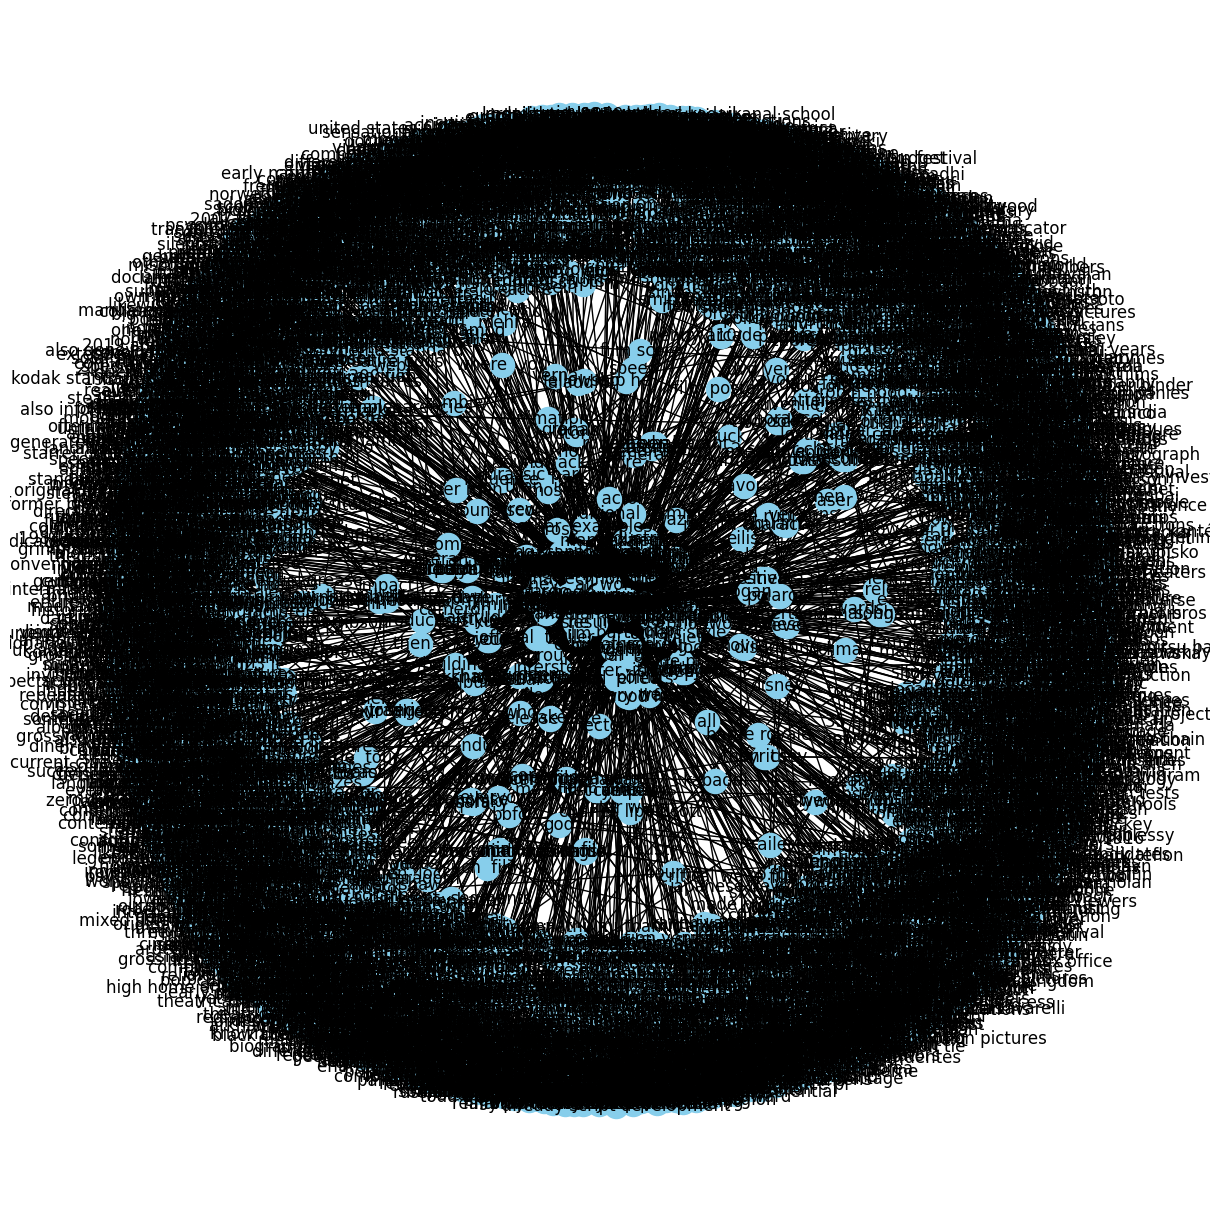

In [ ]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

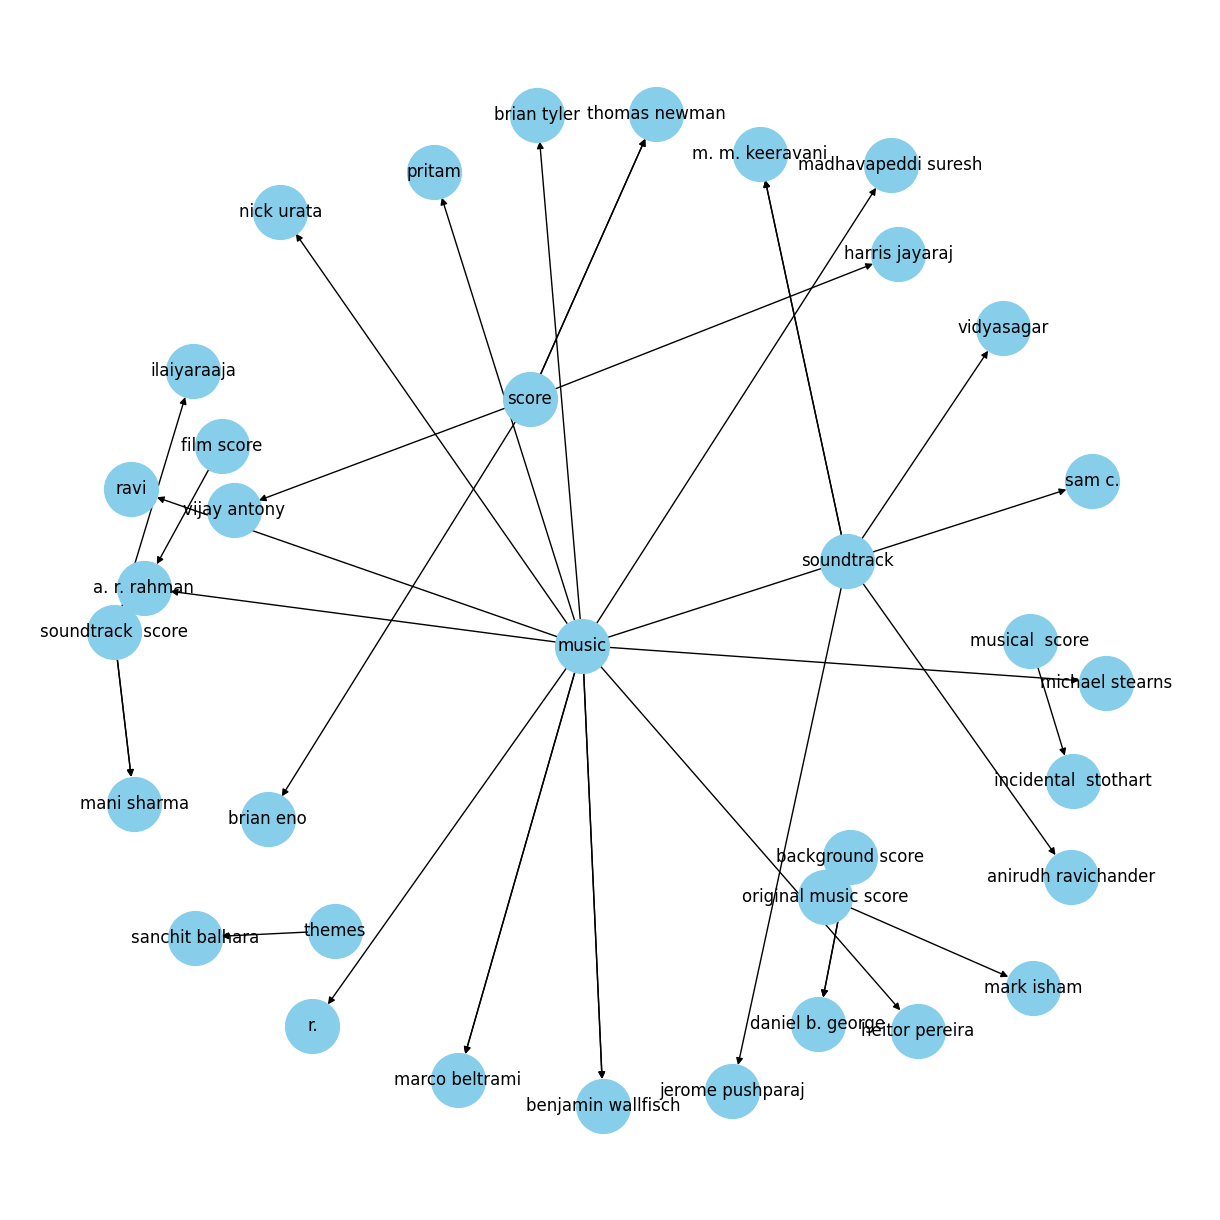

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

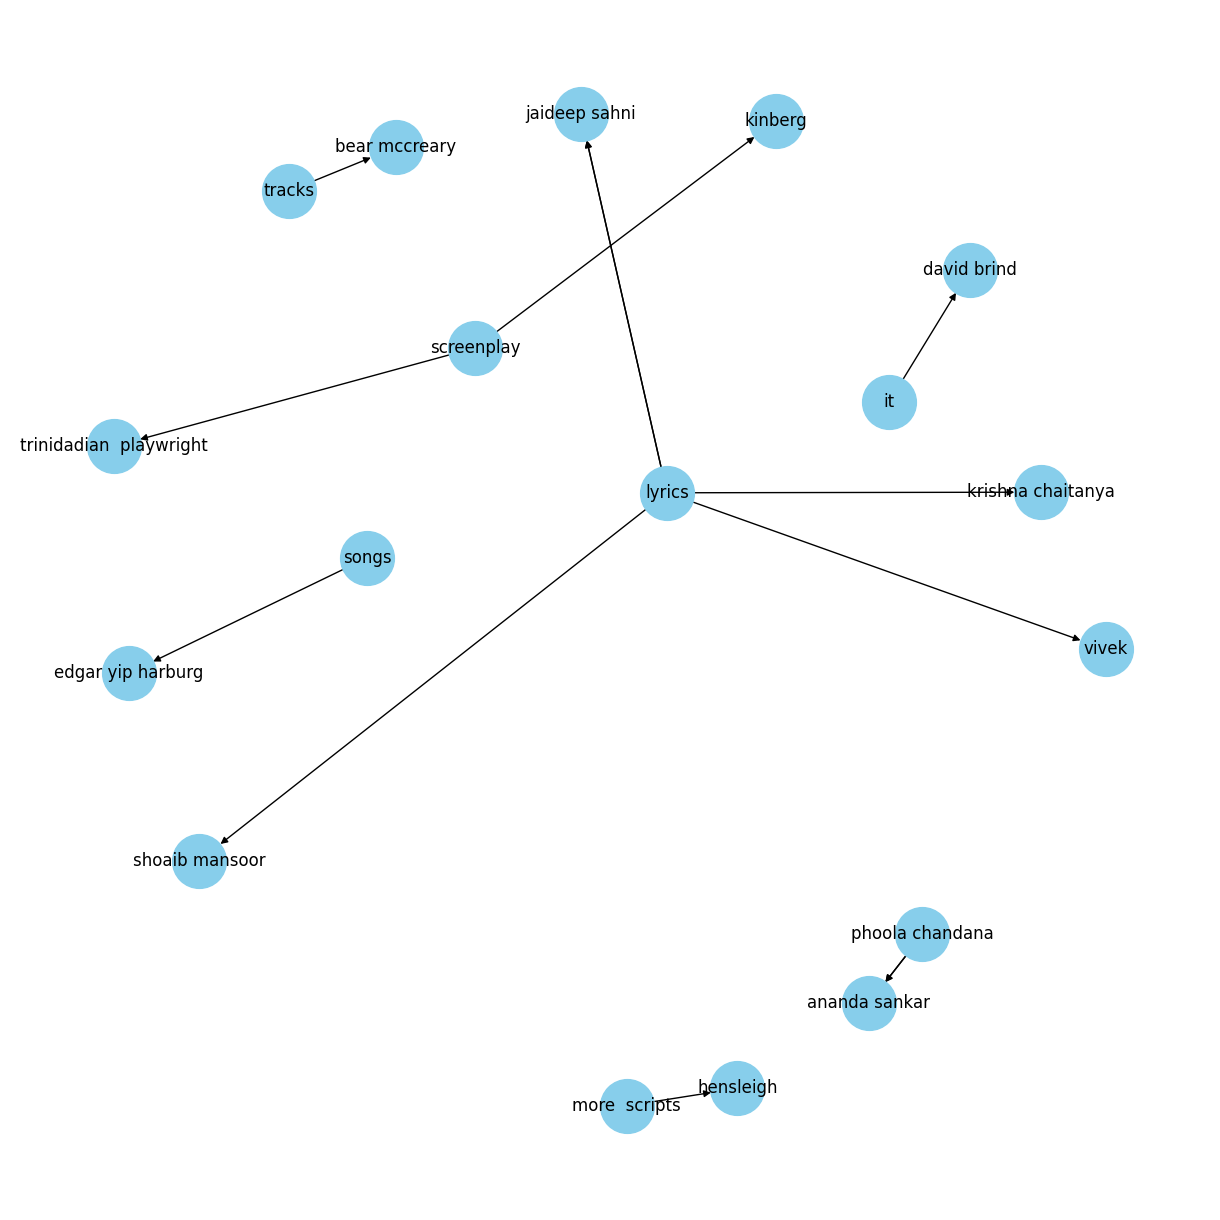

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

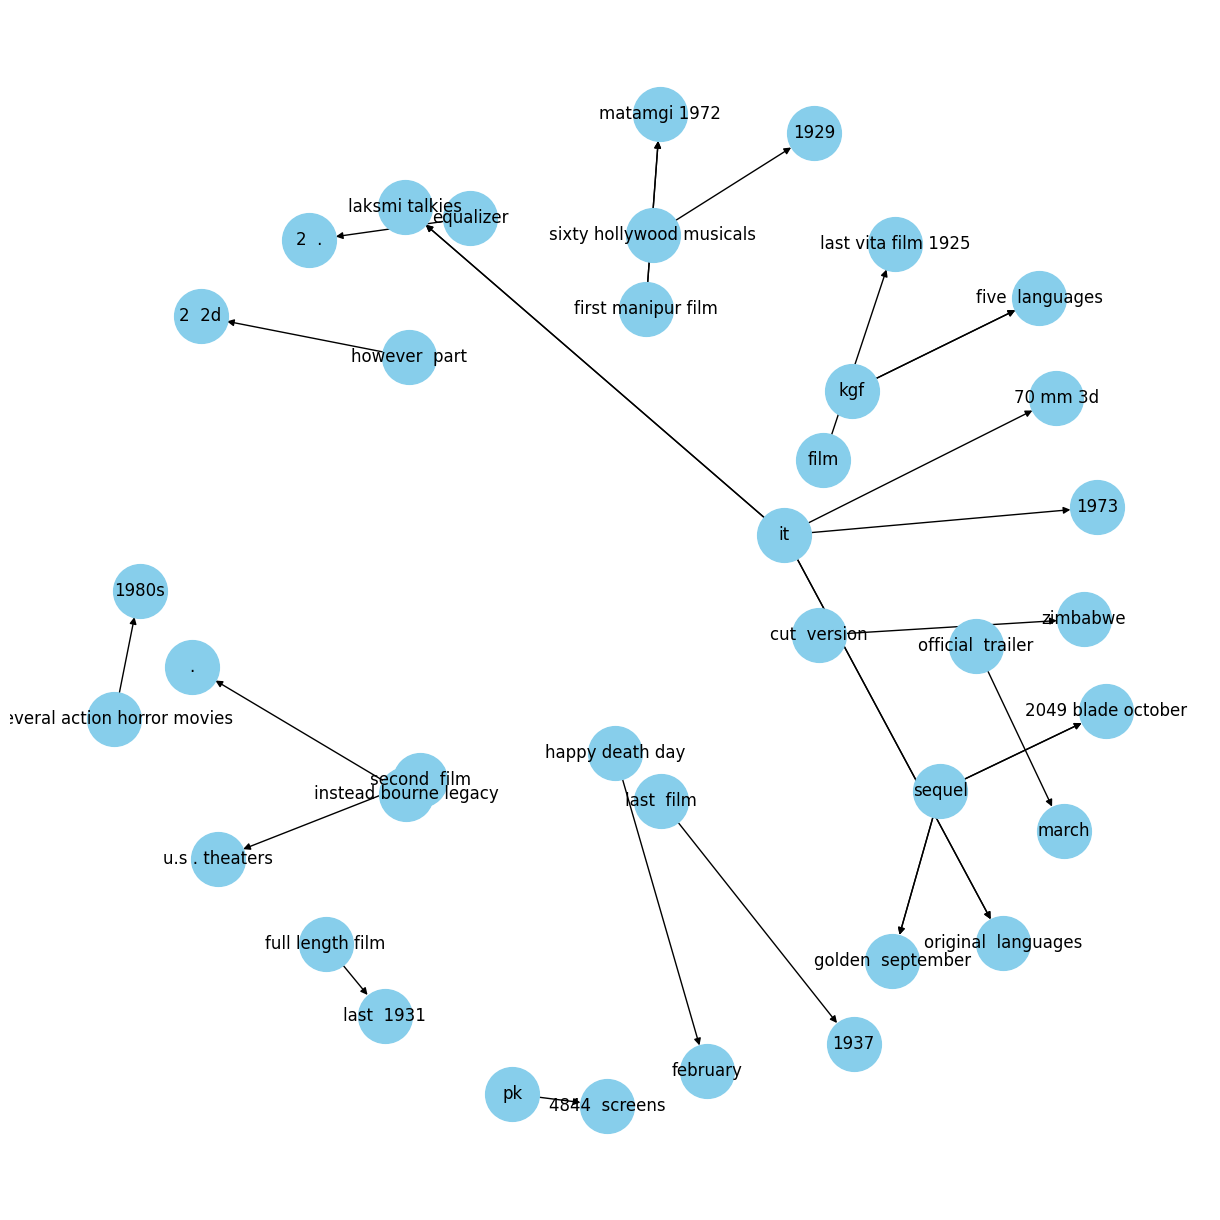

In [ ]:

G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()